### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework.

### Imran Zamin Ali

## Initial Setup

### Imports

In [ ]:
import pandas as pd
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels
from BSE import market_session

### Statistics

We're going to be doing a lot of experiments and statistical tests. Therefore we can make our lives a bit easier by automating them. First lets setup our statistics. Each time we a trade is made it affects the market and how much profit the proceeding traders make. This means that the samples generated **within** each market session is paired rather than independent. Our statistics function determines which test(s) to use based on the flowchart below. To read up on the which tests I used and why please refer to '100 Statistical Tests' by Gopal K Kanji (LINK), which was mentioned in Dave Cliff's leture on empirical methods, as well as the scipy (LINK) statsmodels (https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.AnovaRM.html#statsmodels.stats.anova.AnovaRM) documentation.

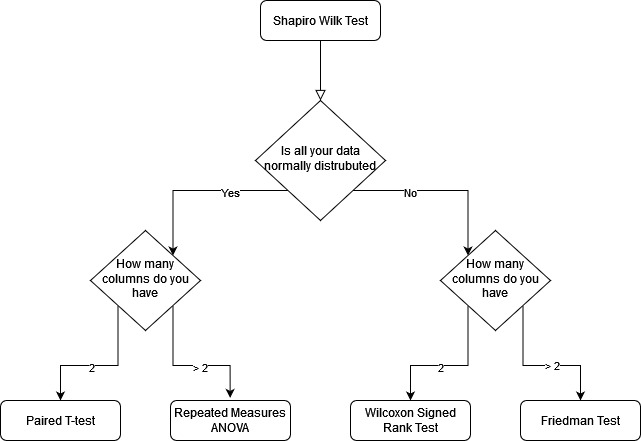

In [ ]:
def run_stat_tests(profits):
    for col in profits.columns:
      print(f'{col}: mean={profits[col].mean()} std={profits[col].std()}')
    print('Check each column if the data is normally distrubuted with the shapiro wilk test:')
    is_normal = True
    # check if the data is normally distributed
    for col in profits.columns:
        _, pvalue = stats.shapiro(profits[col])
        if pvalue < 0.05:
            print(f'Condition: {col}. Reject null hypothesis (p={pvalue}). There is enough evidence to suggest the data is not normally distributed')
            is_normal = False
        else:
            print(f'Condition: {col}. Do not reject null hypothesis (p={pvalue}). There is not enough evidence to suggest the data is not normally distributed')

    columns = [profits[column] for column in profits.columns]
    is_two_dist = len(columns) == 2
    if is_two_dist:
        fig, axes = plt.subplots(1,2)
        sns.kdeplot(data=profits, fill=False, ax=axes[0])
        sns.boxplot(data=profits, ax=axes[1])
        plt.show()
    else:
        sns.violinplot(data=profits, inner='box')
    pvalue = None
    if is_normal:
        test_name = 'paired t-test' if is_two_dist else 'ANOVA test'
        _, pvalue = stats.ttest_rel(*columns) if is_two_dist else stats.f_oneway(*columns)
    else:
        test_name = 'Wilcoxon Signed Rank test' if is_two_dist else 'Friedman test'
        _, pvalue = stats.wilcoxon(*columns) if is_two_dist else stats.friedmanchisquare(*columns)

    print(f'There are {len(columns)} distributions. Therefore using {test_name}')
    if pvalue < 0.05:
        print(f'Reject null hypothesis (p={pvalue}). There is sufficient evidence to suggest groups have a population different mean')
    else:
        print(f'Do not reject null hypothesis (p={pvalue}). There is not enough evidence to suggest the groups have a different population mean')





### Determining the number of traders

Since we're determining the number of each trader type it based on a ratio it makes sense to create a function to calculate this rather than having to do it ourselves each time.

In [ ]:
# given a tuple of the algos, a tuple of the percentages for that trader and the number of traders return the specs
def get_traders_specs(algos, percentages, num_traders):
    if sum(percentages) != 100:
        raise Exception('The percentages should add to 100')
    if len(algos) != len(percentages):
        raise Exception(f'algos len: {len(algos)} %s len: {len(percentages)} are not equal')

    num_traders_each = tuple(round(percent * num_traders / 100) for percent in percentages)
    if sum(num_traders_each) != num_traders:
        raise Exception('num traders each != num traders')
    return list(zip(algos, num_traders_each))

### Running an experiment



> Indented block



In [ ]:
# run n instances of market session. Collect the final profits for each trader for each session and store in a numpy array. Apply the appropriate hypothesis test
def run_experiment(n, market_args, initial_seed):
    # create an empty dataframe
    # traders = market_args[3]
    # buyers = traders['buyers']
    # sellers = traders['sellers']
    # algo_names = list({algo for (algo, _) in buyers+sellers})
    # profits = pd.DataFrame(columns=algo_names)
    profits = pd.DataFrame()

    print(f'n: {n}')
    for i in range(n):
        if i in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]:
          print(i)
        random.seed(initial_seed + i)
        market_session(*market_args)
        trial_id = market_args[0]
        filename = f'{trial_id}_avg_balance.csv'
        file = open(filename, 'r')
        final_entry = (file.readlines()[-1]).split(',')
        #print(len(final_entry))
        #print(final_entry)
        file.close()
        profit_entry = {}
        for j in range(4, len(final_entry)-4, 4):
            col_name = final_entry[j]
            #print(col_name)
            col_val = final_entry[j+3]
            #print(col_val)
            profit_entry[col_name] = round(float(col_val.strip()))

        #print(profit_entry)
        entry_df = pd.DataFrame([profit_entry])
        #profits = profits.append(profit_entry, ignore_index=True)
        profits = pd.concat([profits, entry_df], ignore_index=True)

    run_stat_tests(profits)
    #Freturn profits

### Part A

In [ ]:
sup_range = (310, 310)
dem_range = (250, 490)
num_buyers = 20
num_sellers = 20
r = 50
r_vals = (r, 100 - r)
algos = ('SHVR', 'ZIC')
seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}

#plot_sup_dem(num_buyers, [sup_range], num_sellers, [dem_range], 'fixed')



In [ ]:
start_time = 0
end_time = 3 * 60 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 30
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
verbose = False
dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}
trial_id = 'smith_chart'
initial_seed = 100

n: 5
 SHVR: mean=19671.0 std=2179.702846720167
 ZIC: mean=20950.2 std=2290.796520863431
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Do not reject null hypothesis (p=0.41336944699287415). There is not enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Do not reject null hypothesis (p=0.5744181275367737). There is not enough evidence to suggest the data is not normally distributed


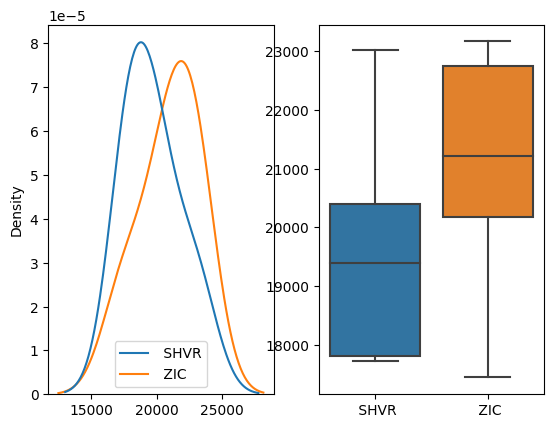

There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.5569723284589401). There is not enough evidence to suggest the groups have a different population mean


In [ ]:
# for i in tqdm(range(n)):
#     random.seed(100) # changing the seed value will give us different seqences of random numbers
#     trial_id = 'smith_chart_'
#     market_session(trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose)

run_experiment(50, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

# TODO create a for loop that runs to n. Changes the seed each time as well as the trial id. Dumps the avgbals. Take the total profits for each trader type from the last line of the csv file and puts it into a dataframe

#

n: 500
50
100
150
200
250
300
350
400
450
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Do not reject null hypothesis (p=0.4035429060459137). There is not enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Do not reject null hypothesis (p=0.3987411558628082). There is not enough evidence to suggest the data is not normally distributed
There are 2 distributions. Therefore using paired t-test
Do not reject null hypothesis (p=0.5090872510360573). There is not enough evidence to suggest the groups have a different population mean


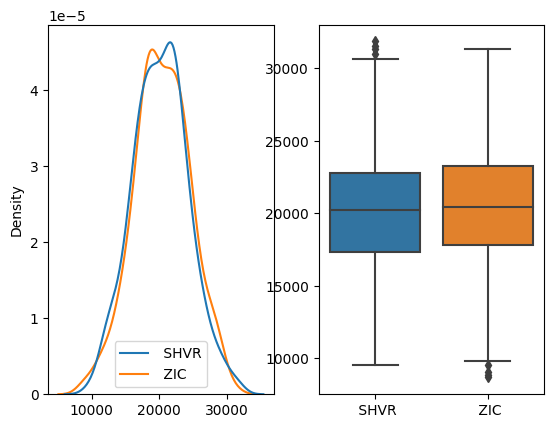

In [ ]:
run_experiment(500, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

### Part B

In [ ]:
def part_b(n):
    r_list = list(range(10, 91, 10))
    for r in r_list:
        r_vals = (r, 100-r)
        seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
        buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
        traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
        print(f'R: {r} {seller_specs}')
        run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)

        print('------------------------------------------------------------------------------------------------------------------------------')

R: 10
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Reject null hypothesis (p=0.04967755824327469). There is enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Do not reject null hypothesis (p=0.06510033458471298). There is not enough evidence to suggest the data is not normally distributed
There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Do not reject null hypothesis (p=0.2373529877703877). There is not enough evidence to suggest the groups have a different population mean
-----------------------------------------------------------------------------------------------------
R: 20
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Do not reject null hypothesis (p=0.37978267669677734). There is not enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Do not reject null hypothesis (p=0.3783277571201

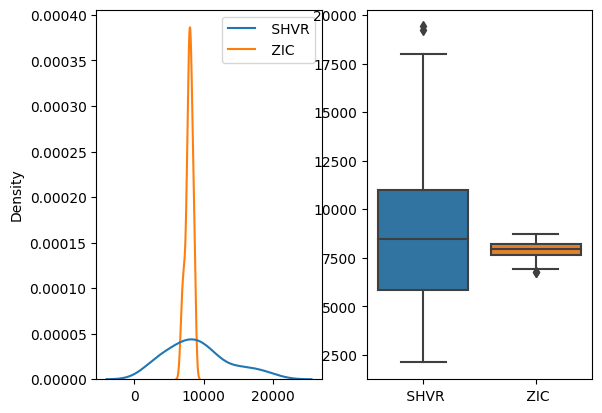

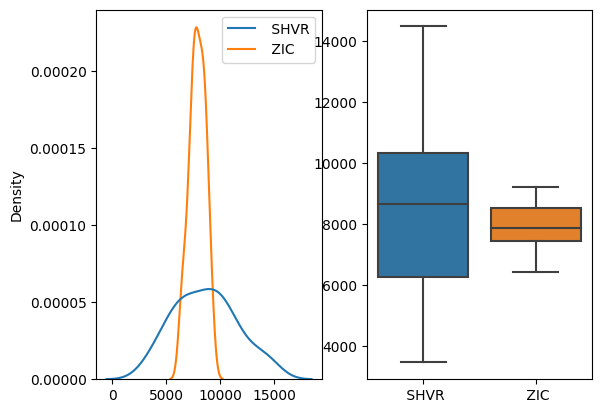

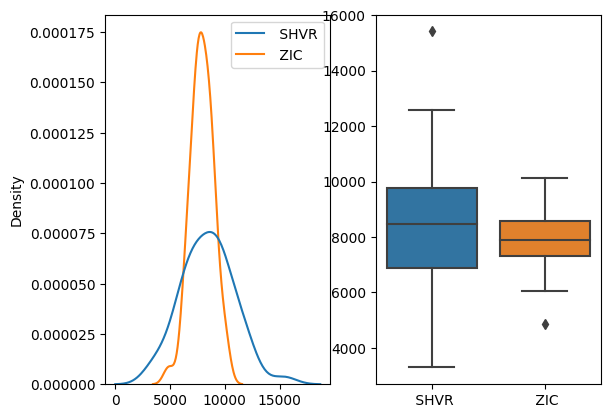

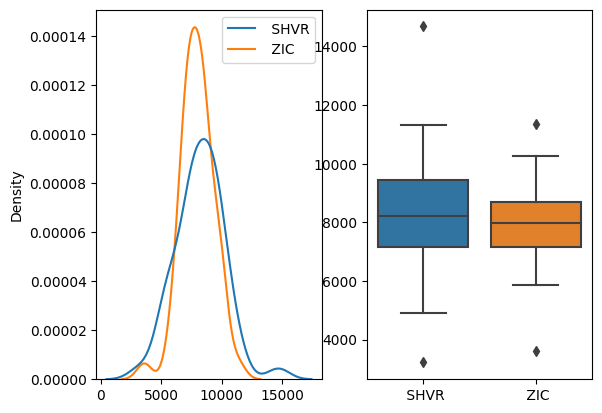

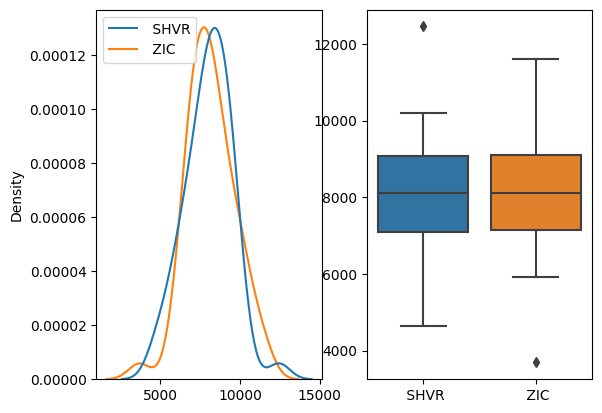

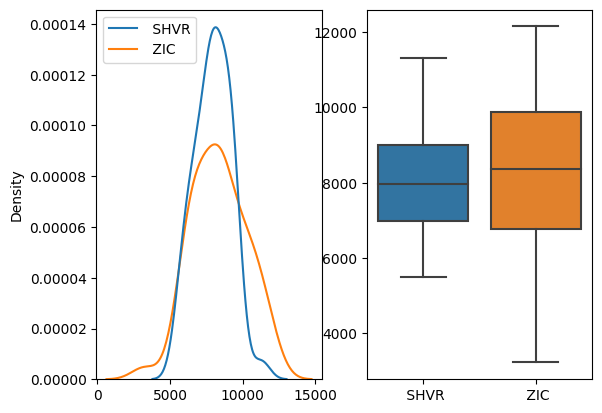

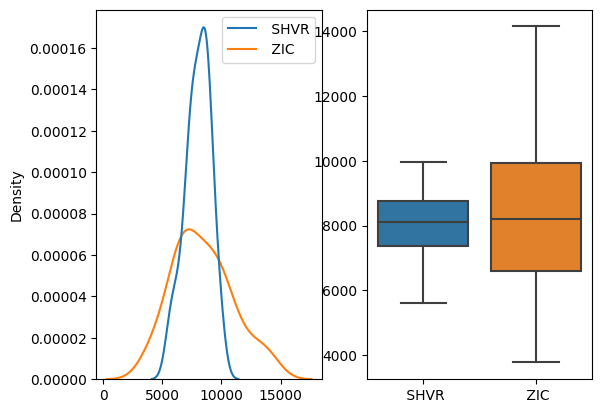

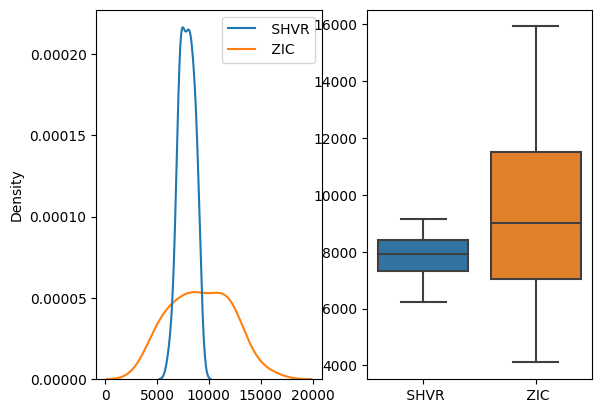

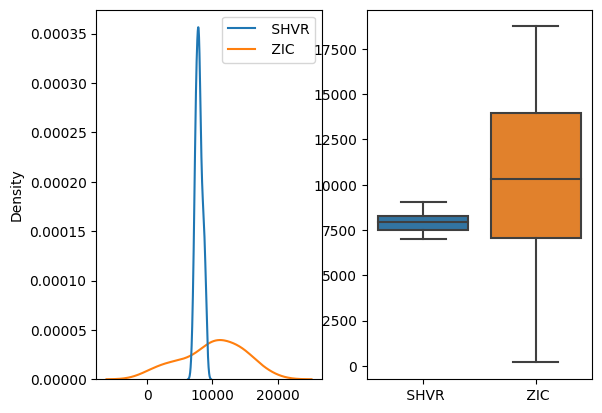

In [ ]:
part_b(50)

R: 10 [('SHVR', 2), ('ZIC', 18)]
n: 500
50
100
150
200
250
300
350
400
450
 SHVR: mean=<bound method NDFrame._add_numeric_operations.<locals>.mean of 0      13085
1      20596
2      11236
3      14792
4      35700
       ...  
495    21941
496     9621
497     5320
498    12978
499    35579
Name:  SHVR, Length: 500, dtype: int64> std=11119.431817819932
 ZIC: mean=<bound method NDFrame._add_numeric_operations.<locals>.mean of 0      20865
1      20058
2      21103
3      20669
4      18345
       ...  
495    19849
496    21298
497    21754
498    20898
499    18381
Name:  ZIC, Length: 500, dtype: int64> std=1263.9560060645042
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition:  SHVR. Reject null hypothesis (p=2.7704594174338126e-09). There is enough evidence to suggest the data is not normally distributed
Condition:  ZIC. Reject null hypothesis (p=1.293036011595916e-09). There is enough evidence to suggest the data is not normally distributed


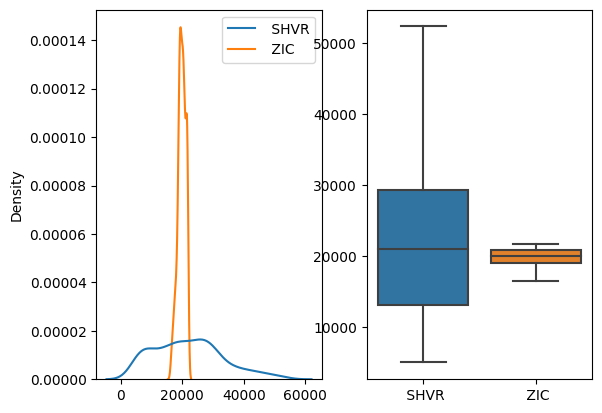

There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Reject null hypothesis (p=0.005269251880274224). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 20 [('SHVR', 4), ('ZIC', 16)]
n: 500
50
100
150
200
250
300
350
400
450
 SHVR: mean=<bound method NDFrame._add_numeric_operations.<locals>.mean of 0       8701
1      16716
2       9064
3      28820
4      25123
       ...  
495    22243
496    13487
497    16677
498    20386
499    35295
Name:  SHVR, Length: 500, dtype: int64> std=7428.865514037207
 ZIC: mean=<bound method NDFrame._add_numeric_operations.<locals>.mean of 0      23011
1      20958
2      23024
3      17898
4      18818
       ...  
495    19605
496    21846
497    20954
498    19951
499    16283
Name:  ZIC, Length: 500, dtype: int64> std=1887.7171092791766
Check each column if the data is normally

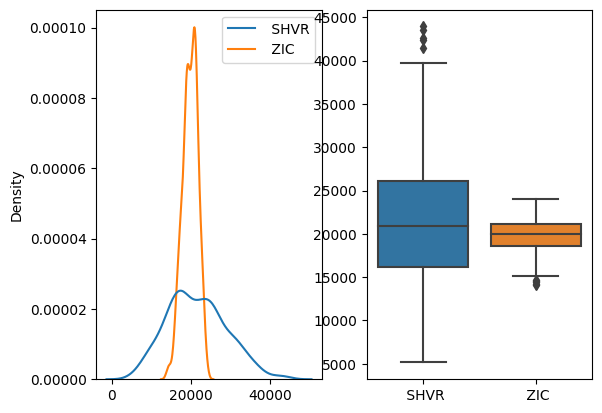

There are 2 distributions. Therefore using Wilcoxon Signed Rank test
Reject null hypothesis (p=0.0011585299551737803). There is sufficient evidence to suggest groups have a population different mean
------------------------------------------------------------------------------------------------------------------------------
R: 30 [('SHVR', 6), ('ZIC', 14)]
n: 500
50
100
150
200
250


In [ ]:
part_b(500)

### Part C

In [ ]:
def part_c(n):
    algos = ('SHVR', 'GVWY', 'ZIC', 'ZIP')
    ratios_list = [[25, 25, 25, 25], [40,20,20,20], [10,30,30,30], [70,10,10,10]]
    n_vals = [n]
    for n in n_vals:
        for i in range(len(ratios_list)):
            for j in range(len(ratios_list[i])):
                seller_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                buyer_specs = get_traders_specs(algos=algos, percentages=tuple(ratios_list[i]), num_traders=num_sellers)
                traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'periodic'}
                print(seller_specs)
                run_experiment(n, (trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose), initial_seed)
                print('-----------------------------------------------------------------------------------------------------')
                if len(set(ratios_list[i])) == 1: # no need to permute if all elements are equal
                    break
                ratios_list[i].append(ratios_list[i].pop(0)) # rotates by 1

In [ ]:
part_c(50)

[('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  GVWY. We cannot reject the null hypothesis (p=0.52). Therefore, data is normally distributed.
Condition  SHVR. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.
Condition  ZIC. We cannot reject the null hypothesis (p=0.48). Therefore, data is normally distributed.
Condition  ZIP. We cannot reject the null hypothesis (p=0.18). Therefore, data is normally distributed.
There are 4 distributions. Therefore using Kruskal-Wallis
Reject null hypothesis. There is sufficient evidence to suggest groups have a population different mean
-----------------------------------------------------------------------------------------------------
[('SHVR', 8), ('GVWY', 4), ('ZIC', 4), ('ZIP', 4)]
n: 50
Check each column if the data is normally distrubuted with the shapiro wilk test:
Condition  GVWY. We cannot reject the n

In [ ]:
part_c(500)

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT.

In [ ]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

C:\Users\izami\AppData\Local\Temp\ipykernel_39204\2932030967.py:3: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


In [ ]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "cw.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 12. Limit is 2000 words.
